**First Method: Statisticl Features Extraction from the Images** 

In [ ]:
! pip install xlsxwriter --quiet
! pip install cv2 --quiet
! pip install scikit-image --quiet
! pip install scikit-learn  --quiet
! pip install opencv-python --quiet
! pip install seaborn --quiet
! pip install openpyxl --quiet

In [9]:
import xlsxwriter
import cv2
import numpy as np
from numpy import asarray
import pandas as pd
import pickle
from skimage import exposure, feature
from matplotlib import pyplot
from scipy.stats import skew, kurtosis
import skimage.measure    
import skimage.feature
import math
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import os
from statistics import mean 
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import preprocessing


**PART 1: FEATURE EXTRACTION**

First of all, we need to preprocess the data: extract nine statisticalfeatures from each image and store the exxtracted numerical data in separate excel file. 

<i>**Following features are extracted from the images:** </i>

<i>Statistical Features:</i>

Mean: The average intensity value of the red channel pixels.<br>

Variance: A measure of the spread of the pixel intensity values, showing how much the pixel values deviate from the mean.<br>

Skewness: Indicates the asymmetry of the pixel intensity distribution.<br>

Kurtosis: Measures the 'tailedness' of the pixel intensity distribution.<br>

Entropy: Quantifies the randomness or unpredictability in the pixel intensity levels.<br>


<i>Texture Features (GLCM Features):</i>


Contrast: It measures the local variations in the gray level of an image. High contrast values indicate a large difference in pixel values, leading to a more textured and varied image appearance.

Energy: It quantifies the uniformity or smoothness of an image. High energy values occur when pixel intensity distribution is more consistent or uniform.

Homogeneity: It measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal. Higher homogeneity indicates less contrast and more uniformity in intensity values.

Correlation: It  measures the joint probability occurrence of the specified pixel pairs. It indicates how correlated a pixel is to its neighborhood.

These features are derived from the Gray Level Co-occurrence Matrix (GLCM), which is a method of examining the spatial relationship between pixels in an image (Gonzalez & Woods, 2018).

In [10]:
def process_image(image_path, bin_label, multy_label):
    """
    Process an image and extract statistical and texture features.

    :param image_path: Path to the image file.
    :param bin_label: Binary label for the image.
    :param multy_label: Multiple label for the image.
    :return: A 1D array of extracted features.
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image from path: {image_path}")
    
    # Extract the Red channel
    R = img[:,:,0]

    # Calculate original statistical features
    mean_R = np.mean(R)
    variance_R = math.sqrt(np.var(R))
    skewness_R = skew(R.reshape(-1))
    kurtosis_R = kurtosis(R.reshape(-1))
    entropy_R = skimage.measure.shannon_entropy(R)

    # Convert R to 8-bit and calculate texture features
    R_ubyte = skimage.util.img_as_ubyte(R)
    glcm = skimage.feature.graycomatrix(R_ubyte, [1], [0], levels=256, symmetric=False, normed=True)
    contrast_R = skimage.feature.graycoprops(glcm, 'contrast')[0][0]
    energy_R = skimage.feature.graycoprops(glcm, 'energy')[0][0]
    homogeneity_R = skimage.feature.graycoprops(glcm, 'homogeneity')[0][0]
    correlation_R = skimage.feature.graycoprops(glcm, 'correlation')[0][0]

    # Combine all features into an array
    features = np.array([mean_R, variance_R, skewness_R, kurtosis_R, entropy_R, 
                         contrast_R, energy_R, homogeneity_R, correlation_R, 
                         bin_label, multy_label])

    # Handle NaN/INF values
    features = np.nan_to_num(features)

    return features.reshape(1, -1)

In [11]:
def process_directory(input_dir, bin_label, multy_label, out_sheet, start_row):
    """
    Process all images in a directory and write their features to an Excel sheet.

    :param input_dir: Directory containing image files.
    :param bin_label: Binary label for images in this directory.
    :param multy_label: Multiple label for images in this directory.
    :param out_sheet: The Excel worksheet to write data to.
    :param start_row: The starting row index for writing to the worksheet.
    :return: Updated row index after writing all data.
    """
    filenames = os.listdir(input_dir)
    image_filenames = sorted([f for f in filenames if f.endswith('.jpg') or f.endswith('.png')],
                             key=lambda x: int(''.join(filter(str.isdigit, x))))

    for i, filename in enumerate(image_filenames, start=start_row):
        file_path = os.path.join(input_dir, filename)
        features = process_image(file_path, bin_label, multy_label)
        out_sheet.write_row(i, 0, features[0])
    
    return i + 1  # Return the next starting row index

In [12]:
# Create Excel workbook and worksheet
outWorkbook = xlsxwriter.Workbook(r"/Users/kanykeimairambekova/Desktop/ML Project/results/All_final.xlsx")
outSheet = outWorkbook.add_worksheet()

# Write headers to the worksheet
headers = ["Mean", "Variance", "Skewness", "Kurtosis", "Contrast", "Entropy", "Energy", "Homo", "Corre", "Bin_lable", "Multy_lable"]
for col, header in enumerate(headers):
    outSheet.write(0, col, header)

# Define input directories and their corresponding labels
directories = [
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Non_Demented", 0, 0),
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Demented/Very_Mild_Demented", 1, 1),
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Demented/Mild_Demented", 1, 2),
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Demented/Moderate_Demented", 1, 3),
]

# Process each directory and write features to the worksheet
row_index = 1  # Start writing from the second row (after headers)
for input_dir, bin_label, multy_label in directories:
    row_index = process_directory(input_dir, bin_label, multy_label, outSheet, row_index)

# Close the workbook
outWorkbook.close()

**PART 2: PREPROCESSING**

In [13]:
# Importing the dataset
dataset = pd.read_excel(r"/Users/kanykeimairambekova/Desktop/ML Project/results/All_final.xlsx")
X = dataset.iloc[:, 0:9].values
y_bin = dataset.iloc[:, 9].values

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.25, random_state= 42, shuffle = True )

In [14]:
dataset.describe()

,Mean,Variance,Skewness,Kurtosis,Contrast,Entropy,Energy,Homo,Corre,Bin_lable,Multy_lable
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,71.048212,82.730473,0.634284,-1.196703,5.242659,320.620526,0.408594,0.473720,0.976324,0.500000,0.660000
std,7.096170,7.019377,0.124257,0.189970,0.156537,47.704051,0.018667,0.021643,0.004440,0.500039,0.751324
min,33.153076,43.579657,0.377495,-1.545760,4.585930,88.542323,0.382724,0.443315,0.952584,0.000000,0.000000
25%,67.138550,80.124016,0.541814,-1.346025,5.142825,293.982007,0.394585,0.456643,0.973300,0.000000,0.000000
50%,71.661896,83.561896,0.626488,-1.218542,5.297226,324.019131,0.400810,0.465228,0.976624,0.500000,0.500000
75%,76.180237,87.246408,0.715649,-1.086596,5.366832,352.609283,0.419125,0.488514,0.979569,1.000000,1.000000
max,86.468506,97.846576,1.011682,-0.397026,5.458815,489.758858,0.467170,0.542425,0.987374,1.000000,3.000000


As features in this dataset have different varying ranges, models that are sensitive to the scale of data (like SVMs, k-nearest neighbors, and neural networks) can perform poorly. Beacuse of that, we are applying Standard Scaler to normalize the features so that each feature contributes approximately proportionately to the final distance.

In [15]:
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)

**PART 2: CLASSIFICATION, HYPERPARAMETERS TUNING AND PERFORMANCE EVALUATION**

Now, we will apply classification models on the dataset and use GridSearch algorithm to tune hyperparameters.

In [16]:
# Function for metrics calculation
def metrics_calc(y_test, y_pred):
    # Confusion matrix and heatmap
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    print("Confusion Matrix:\n", cm)

    # Other metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

**SVM classifier with GridSearchCV**

In [17]:
param_grid = {'C': [1, 10, 50, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, verbose=3, cv=5)
grid.fit(X_train_norm, y_train)

# Best model from GridSearch
SVM_best_model = grid.best_estimator_

# Prediction and accuracy
y_pred = SVM_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.714 total time=   0.2s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.715 total time=   0.2s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.701 total time=   0.2s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.692 total time=   0.2s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.690 total time=   0.2s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.733 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.732 total time=   0.2s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.713 total time=   0.2s
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.724 total time=   0.2s
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.691 total time=   0.2s
[CV 1/5] END ....C=1, gamma=auto, kernel=linear;, score=0.714 total time=   0.2s
[CV 2/5] END ....C=1, gamma=auto, kernel=linear;

Confusion Matrix:
 [[570 257]
 [140 633]]
Accuracy: 0.751875
Precision: 0.7112359550561798
Recall: 0.8188874514877102
F1 Score: 0.7612748045700541


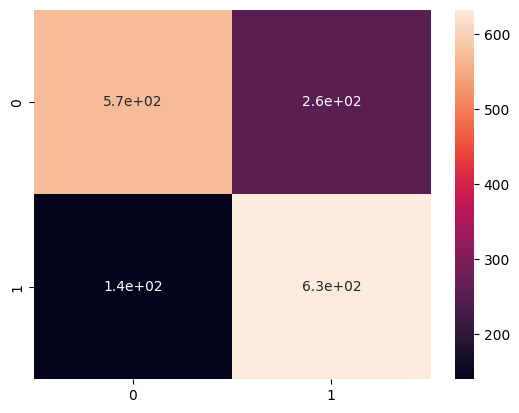

In [18]:
# Calculate evaluation metrics for SVM
metrics_calc(y_test, y_pred)

**kNN classifier with GridSearchCV**

In [19]:
k_range = list(range(3, 10))
leaf_range = list(range(10, 40))
param_grid = {'n_neighbors': k_range, 'leaf_size': leaf_range}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3, scoring='accuracy')
grid.fit(X_train_norm, y_train)

# Best model from GridSearch
kNN_best_model = grid.best_estimator_

# Prediction and accuracy on the test set
y_pred = kNN_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_}'
      f'\nAccuracy for 5-fold CV: {grid.best_score_}'
      f'\nAccuracy for the test set: {accuracy}')
     


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV 1/5] END .......leaf_size=10, n_neighbors=3;, score=0.761 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors=3;, score=0.757 total time=   0.0s
[CV 3/5] END .......leaf_size=10, n_neighbors=3;, score=0.718 total time=   0.0s
[CV 4/5] END .......leaf_size=10, n_neighbors=3;, score=0.739 total time=   0.0s
[CV 5/5] END .......leaf_size=10, n_neighbors=3;, score=0.748 total time=   0.0s
[CV 1/5] END .......leaf_size=10, n_neighbors=4;, score=0.740 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors=4;, score=0.734 total time=   0.0s
[CV 3/5] END .......leaf_size=10, n_neighbors=4;, score=0.727 total time=   0.0s
[CV 4/5] END .......leaf_size=10, n_neighbors=4;, score=0.738 total time=   0.0s
[CV 5/5] END .......leaf_size=10, n_neighbors=4;, score=0.726 total time=   0.0s
[CV 1/5] END .......leaf_size=10, n_neighbors=5;, score=0.767 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors

Confusion Matrix:
 [[600 227]
 [196 577]]
Accuracy: 0.735625
Precision: 0.7176616915422885
Recall: 0.7464424320827943
F1 Score: 0.7317691819911222


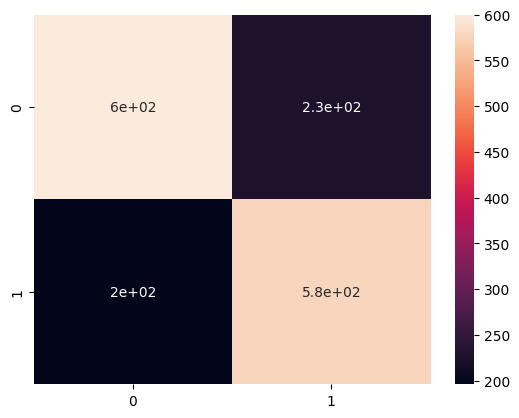

In [20]:
# Calculate evaluation metrics for kNN
metrics_calc(y_test, y_pred) 

**Gaussian NB classifier with GridSearchCV**

In [21]:
param_grid = {
            'priors': [None],
            'var_smoothing': [1e-9, 1e-6, 1e-12],
         }
grid = GridSearchCV(GaussianNB(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

Gaussian_NB_best_model = grid.best_estimator_
Gaussian_NB_best_model.fit(X_train_norm, y_train)
y_pred = Gaussian_NB_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..priors=None, var_smoothing=1e-09;, score=0.694 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-09;, score=0.674 total time=   0.0s
[CV 3/5] END ..priors=None, var_smoothing=1e-09;, score=0.681 total time=   0.0s
[CV 4/5] END ..priors=None, var_smoothing=1e-09;, score=0.673 total time=   0.0s
[CV 5/5] END ..priors=None, var_smoothing=1e-09;, score=0.672 total time=   0.0s
[CV 1/5] END ..priors=None, var_smoothing=1e-06;, score=0.694 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-06;, score=0.674 total time=   0.0s
[CV 3/5] END ..priors=None, var_smoothing=1e-06;, score=0.681 total time=   0.0s
[CV 4/5] END ..priors=None, var_smoothing=1e-06;, score=0.673 total time=   0.0s
[CV 5/5] END ..priors=None, var_smoothing=1e-06;, score=0.672 total time=   0.0s
[CV 1/5] END ..priors=None, var_smoothing=1e-12;, score=0.694 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-12;,

Confusion Matrix:
 [[592 235]
 [255 518]]
Accuracy: 0.69375
Precision: 0.6879150066401063
Recall: 0.6701164294954722
F1 Score: 0.6788990825688074


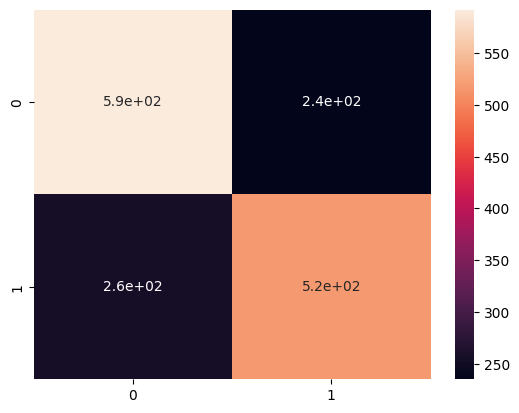

In [22]:
# Calculate evaluation metrics for NB
metrics_calc(y_test, y_pred) 

**LR classifier with GridSearchCV**

In [23]:
# LR Classifier 
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l2"], 'tol' : [0.0001, 0.001, 0.01, 0.1], 'max_iter':[1000, 10000]}
grid = GridSearchCV( LogisticRegression(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

LR_best_model = grid.best_estimator_
LR_best_model.fit(X_train_norm, y_train)
y_pred = LR_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.706 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.700 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.688 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.685 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.682 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.706 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.700 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.688 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.685 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.682 total time=   0.0s
[CV 1/5] END 

Confusion Matrix:
 [[547 280]
 [185 588]]
Accuracy: 0.709375
Precision: 0.6774193548387096
Recall: 0.7606727037516171
F1 Score: 0.7166361974405849


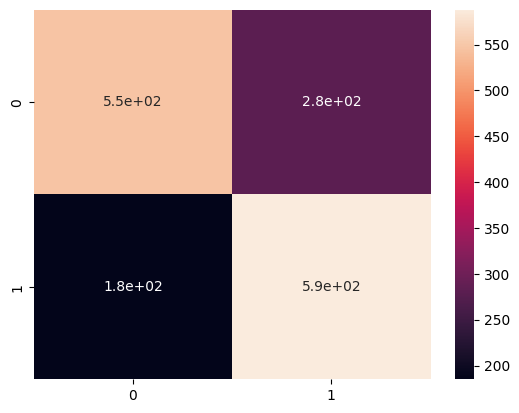

In [24]:
# Calculate evaluation metrics for LR
metrics_calc(y_test, y_pred)

**DecisionTree Classifier with GridSearch**

In [25]:
param_grid = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [4, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0.1, 0.25, 0.5]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

DTree_best_model = grid.best_estimator_
DTree_best_model.fit(X_train_norm, y_train)
y_pred = DTree_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.699 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.708 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.694 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.682 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.684 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.25;, score=0.694 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.25;, score=0.711 total time=   0.0s
[CV 3/5] END max_depth=2, min_sa

Confusion Matrix:
 [[536 291]
 [198 575]]
Accuracy: 0.694375
Precision: 0.663972286374134
Recall: 0.7438551099611902
F1 Score: 0.7016473459426479


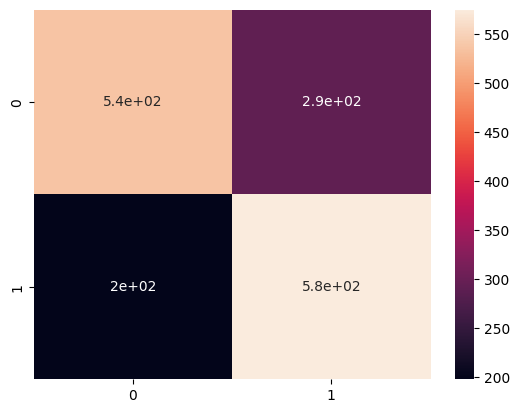

In [26]:
# Calculate evaluation metrics for DT
metrics_calc(y_test, y_pred)

**Random Forest classifier with GridSearch**

In [27]:
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=3)
grid.fit(X_train_norm, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_norm)
accuracy2 = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy2} ')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.722 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.741 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.709 total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.706 total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.690 total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.719 total time=   1.4s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.739 total time=   1.4s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.715 total time=   1.4s
[CV 4/5] END criterion=gini, max_depth=4, max_feat

Confusion Matrix:
 [[549 278]
 [154 619]]
Accuracy: 0.73
Precision: 0.6900780379041248
Recall: 0.8007761966364813
F1 Score: 0.741317365269461


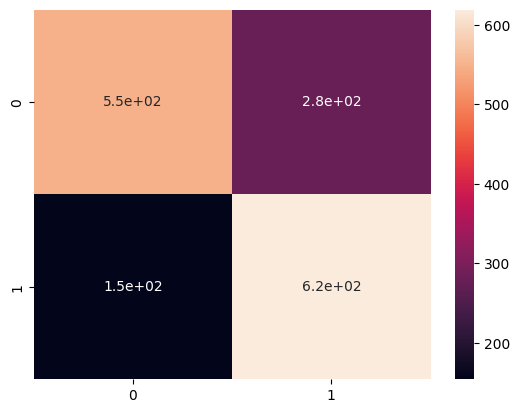

In [28]:
# Calculate evaluation metrics for RF
metrics_calc(y_test, y_pred)

Below, we can see the performance plot of different models.

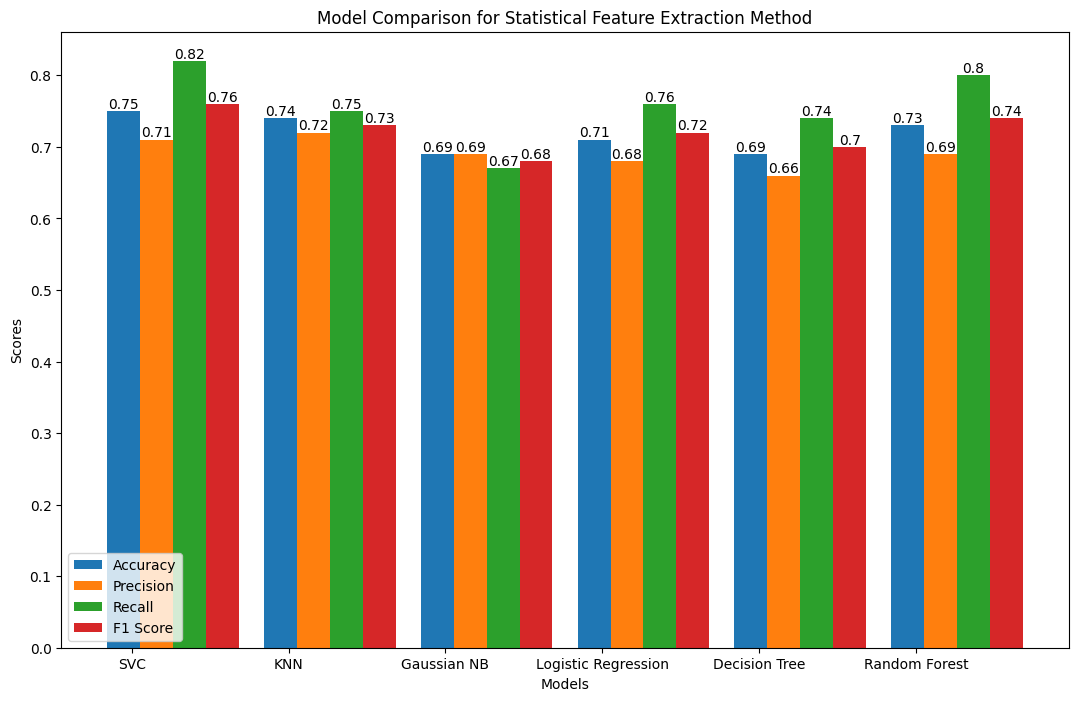

In [44]:
metrics = {
    'SVC': {
        'Accuracy': 0.75,  
        'Precision': 0.71,  
        'Recall': 0.82,  
        'F1 Score': 0.76  
    },
    'KNN': {
        'Accuracy': 0.74,
        'Precision': 0.72,
        'Recall': 0.75,
        'F1 Score': 0.73
    },
    'Gaussian NB': {
        'Accuracy': 0.69,
        'Precision': 0.69,
        'Recall': 0.67,
        'F1 Score': 0.68
    },
    'Logistic Regression': {
        'Accuracy': 0.71,
        'Precision': 0.68,
        'Recall': 0.76,
        'F1 Score': 0.72
    },
    'Decision Tree': {
        'Accuracy': 0.69,
        'Precision': 0.66,
        'Recall': 0.74,
        'F1 Score': 0.70
    },
    'Random Forest': {
        'Accuracy': 0.73,
        'Precision': 0.69,
        'Recall': 0.80,
        'F1 Score': 0.74
    },
    
}

fig, ax = plt.subplots(figsize=(13, 8))
model_names = list(metrics.keys())
metric_names = list(metrics[next(iter(metrics))].keys())
metric_values = np.array([[metrics[model][metric] for metric in metric_names] for model in model_names])

n_models = len(model_names)
n_metrics = len(metric_names)

bar_width = 0.21
indices = np.arange(n_models)

for i in range(n_metrics):
    bars = ax.bar(indices + i * bar_width, metric_values[:, i], bar_width, label=metric_names[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison for Statistical Feature Extraction Method')
ax.set_xticks(indices + bar_width / n_metrics)
ax.set_xticklabels(model_names)

ax.legend(loc='lower left')

plt.show()
